In [18]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import random
from pathlib import Path

import numpy as np
import pandas as pd

from moabb.datasets import BNCI2014_009
from moabb.paradigms import P300
from moabb.evaluations import WithinSessionEvaluation

from mne.decoding import Vectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace

In [19]:
SEED = 42
np.random.seed(SEED); random.seed(SEED)

In [20]:
# Dataset
dataset = BNCI2014_009()
paradigm = P300()

dataset.subject_list = dataset.subject_list[:3]

H5_DIR = Path.home() / "moabb_models"
H5_DIR.mkdir(parents=True, exist_ok=True)

evaluation = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=[dataset],
    hdf5_path=H5_DIR,
    n_jobs=1,
    overwrite=False
)

In [21]:
pipelines = {
    "Vec+LR": make_pipeline(
        Vectorizer(),
        StandardScaler(with_mean=False),
        LogisticRegression(max_iter=1000, random_state=SEED)
    ),
    "xDAWN+TS+LDA": make_pipeline(
        XdawnCovariances(n_components=4, estimator='oas'),
        TangentSpace(metric="riemann"),
        LDA()
    ),
    "xDAWN+TS+LinearSVM": make_pipeline(
        XdawnCovariances(n_components=4, estimator='oas'),
        TangentSpace(metric="riemann"),
        SVC(kernel="linear", probability=True, random_state=SEED)
    ),
}

In [22]:
results = evaluation.process(pipelines)

BNCI2014-009-WithinSession:   0%|          | 0/3 [00:00<?, ?it/s]


In [23]:
results_df = results.sort_values(["score"], ascending=False)
results_df.head()

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
13,0.953103,0.329369,576.0,2,1,16,3,BNCI2014-009,xDAWN+TS+LinearSVM
10,0.944792,0.330325,576.0,1,1,16,3,BNCI2014-009,xDAWN+TS+LinearSVM
22,0.942001,0.094270,576.0,2,1,16,3,BNCI2014-009,Vec+LR
12,0.940932,0.362553,576.0,2,0,16,3,BNCI2014-009,xDAWN+TS+LinearSVM
16,0.940702,0.348585,576.0,3,1,16,3,BNCI2014-009,xDAWN+TS+LinearSVM


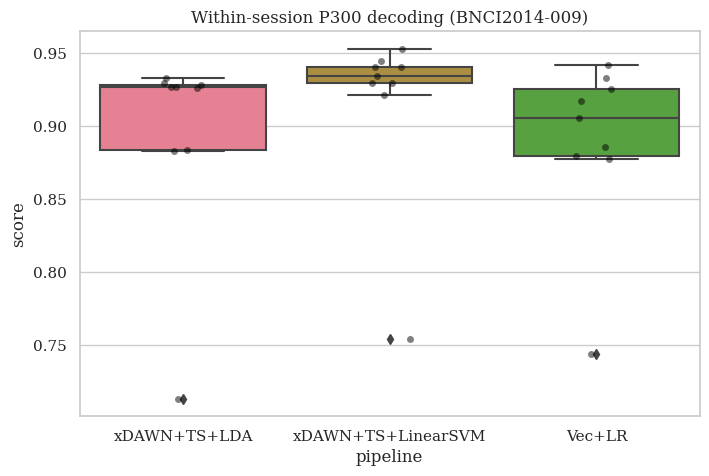

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=results, x="pipeline", y="score")
sns.stripplot(data=results, x="pipeline", y="score", color="black", alpha=0.5)
plt.title("Within-session P300 decoding (BNCI2014-009)")
plt.show()

In [25]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# fpr, tpr, _ = roc_curve(labels, y_score, pos_label="Target")  
# roc_auc = auc(fpr, tpr)

In [26]:
# plt.figure(figsize=(6,5))
# plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic (P300)")
# plt.legend(loc="lower right")
# plt.show()